In [674]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import train_test_split
import deepxde as dde
from fourier import FNO1d
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
import warnings; warnings.simplefilter('ignore')
from utilities import set_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)


In [675]:
def dynamics(x, control):
    xdot = (rho*mu(x[1]) - b - control)*x[0]
    sdot = control*(s_in-x[1])-mu(x[1])*x[0]
    return np.array([xdot, sdot])

def mu(s):
    a = 7.0/2.0
    return (a*s)/(1+s+s**2)

def controller(state):
    mu_s = mu(state[1])
    mu_s_des = mu(s_des)
    if state[1] > s_des:
        coeff = 0
    else:
        coeff = np.pow(abs(mu_s - mu_s_des), 1+alpha)
    return (D_star*mu_s*state[0]) / (mu_s_des*x_des) + (delta * b) / np.pow(mu_s_des, 1+alpha) * coeff

def simulate_system(x0, T, dt):
    t = np.arange(0, T, dt)
    res = np.zeros((len(t), len(x0)))
    res[0] = x0
    for i in range(1, len(t)):
        res[i] = res[i-1] + dt*dynamics(res[i-1], controller(res[i-1]))
    return res


def compute_predictors(state, controls, D_estimate, x, _model):
    integral_tmp = np.zeros((len(x), 2))
    res = np.zeros((len(x), 2))
    res[0] = np.copy(state)
    for i in range(1, len(x)):
        integral_tmp[i] = dynamics(res[i-1], controls[i-1]) 
        res[i] = res[0] + D_estimate*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1])])
    return res

def simulate_system_with_delay_no_estimate(x0, T, dt, dx, D):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    res = np.zeros((len(t), len(x0)))
    res[0] = x0
    pde_sol = np.zeros((len(t), len(x)))
    pde_sol[0] = np.full(len(x), controller(x0))
    for i in range(1, nt):
        if i % 100 == 0:
            print(i , "/", nt)
        control = controller(compute_predictors(res[i-1], pde_sol[i-1], D, x, None)[-1])
        #control = controller(res[i-1])
        pde_sol[i][0:nx-1] =  pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = control
        res[i] = res[i-1] + dt*dynamics(res[i-1], pde_sol[i][0])
    return res

def mu_deriv_s(state):
    return -alpha*(state[1]**2 - 1) / ((state[1]**2 + state[1]+ 1) ** 2)

def control_deriv_p(state):
    mu_s = mu(state[1])
    mu_s_des = mu(s_des)
    mu_s_deriv = mu_deriv_s(state)
    firstComponent = D_star*mu_s / (mu_s_des*x_des)
    if state[1] < s_des:
        coeff = 0
    else:
        coeff = (delta*b) / np.pow(mu_s_des, 1+alpha) * -1*(1+alpha)*np.pow(abs(mu_s - mu_s_des), alpha)*mu_s_deriv
    secondComponent = D_star*mu_s_deriv*state[0] /  (mu_s_des*x_des)  + coeff
    return np.array([firstComponent, secondComponent])

def solve_delay_integral(predictors, controls, D_estimate, x):
    f_zero = dynamics(predictors[0], controls[0])
    q = np.array([control_deriv_p(p).dot(f_zero) for p in predictors])  # q[i] calculation
    q_x = np.gradient(q, x[1])
    controls_predictors = np.array([controller(p) for p in predictors])
    w = controls - controls_predictors  # Vectorized w calculation
    w_x = np.gradient(w, x[1])
    integral = np.trapz((1+x)*(q*np.sign(w) + q_x*np.sign(w_x)), x=x)
    return 2*np.sign(w_x[-1])*q[-1] + integral

def simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=None, model=None, verbose=False, update=True):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    
    res = np.zeros((len(t), len(x0)))
    res[0] = x0
    
    pde_sol = np.zeros((len(t), len(x)))
    pde_sol[0] = np.full(len(x), controller(x0))
    pde_est = np.zeros((len(t), len(x)))
    pde_est[0] = np.full(len(x), controller(x0))

    controls = []
    predictions = [x0]
    delays = [D_est]
    # Setup predictor func
    if predictor_func is None:
        predictor_func = compute_predictors
    for i in range(1, nt):
        if i % 100 == 0 and verbose:
            print(i , "/", nt)
        # Compute the predictors.  Ensure first value is correct. 
        predictor_arr = predictor_func(res[i-1], pde_est[i-1], D_est, x, model)
        # predictor_arr[0] = res[i-1]
        # Save data for plotting
        delays.append(D_est)
        predictions.append(predictor_arr)
        controls.append(pde_sol[i-1][nx-1])

        if update:
            # Update delay estimator 
            d_dot = solve_delay_integral(predictor_arr, pde_est[i-1], D_est, x)
            D_est = min(max(D_est + dt*gamma*d_dot, DUnder), DOver)
        # Get control estimate
        control =  max(controller(predictor_arr[-1]), 0)
        
        # Update true delay PDE
        pde_sol[i][0:nx-1] =  pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = control
        
        # Update estimated PDE
        pde_est[i][0:nx-1] =  pde_est[i-1][0:nx-1] + dt/(D_est*dx) * (pde_est[i-1][1:nx] - pde_est[i-1][0:nx-1])
        pde_est[i][-1] = control

        # Update ODE
        res[i] = res[i-1] + dt*dynamics(res[i-1], pde_sol[i][0])
    return res, predictions, controls, pde_est, delays

In [676]:
def gen_dataset(num_data, state_bounds, state_mean, dUpper, dLower, sample_rate, dt, T, dx, D):
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    if(num_data % sample_rate != 0):
        raise Exception("Please ensure num_data % sample_rate = 0")
    if(len(t) % sample_rate != 0):
        raise Exception("Please ensure int(T/dt)+1 % sample_rate = 0")
    inputs = np.zeros((num_data, len(x), 4))
    outputs = np.zeros((num_data, len(x), 2))
    index = 0
    start_time = time.time()
    print("Generating", num_data, "values with sample rate", sample_rate)
    print("This will require simulating", int(num_data/sample_rate), "Trajectories")
    for i in range(int(num_data/sample_rate)):
        sample_locs = np.random.choice(np.arange(int(len(t)/sample_rate)-1, len(t)-1), size=sample_rate, replace=False)
        if i % 5 == 0:
            print("Completed:", i, "/", int(num_data/sample_rate))
        init_cond = np.array([np.random.uniform(state_mean[0]-state_bounds[0], state_mean[0]+state_bounds[0]),\
                              np.random.uniform(state_mean[1]-state_bounds[1], state_mean[1]+state_bounds[1])])
        D = np.random.uniform(dLower, dUpper)
        states, predictions, _, pde_sol, delays = simulate_system_with_delay_estimate(init_cond, T, dt, dx, D, D_est)
        if np.isnan(np.sum(states)): 
            print("NaN EXAMPLE, Gamma needs retuning")
        for i in range(len(sample_locs)):
            val = int(sample_locs[i])
            inputs[index, :, 2:4] =  np.vstack((states[val-1],)* len(x))
            inputs[index, :, 0] = np.repeat(delays[val], len(x))
            inputs[index, :, 1] = np.copy(pde_sol[val-1])
            outputs[index, :] = np.copy(predictions[val])
            index += 1
    end_time = time.time()
    inputs = inputs.reshape((num_data, len(x)*4))
    outputs = outputs.reshape((num_data, len(x)*2))
    delays_est = delays_est.reshape((num_data, len(x)))
    np.save("datasets/inputs.npy", inputs)
    np.save("datasets/outputs.npy", outputs)
    print("Generated successfully. Total time:", end_time-start_time)

In [678]:
# Setup simulation parameters
dt = 0.005
T = 15
dx = 0.01
x = np.arange(0, 1, dx)

# Setup initial condition
x0 = [2, 2]

# Setup physical system parameters
D_star = 0.9
b = 0.1 
rho = 1

# Setup desired equilibrium
x_des = 3
s_des = 2
s_in = 2+10.0/3.0
delta = 10
alpha = 0.5

# Setup d estimator paramters
gamma = 1 

# Setup delays
D = 1.5
DOver = 2
DUnder = 1

# Setup dataset generation parameters
dUpper=1.6
dLower=1.4
D_est = 1.8
state_bounds=[0.1, 0.1]
num_data = 100000
sample_rate = 1000

# device = "mps" - m1 mac with gpu
# device = "cuda" - nvidia gpu

<h4> Comment out this line if you want to generate your own dataset. Otherwise, place the corresponding files in the
/datasets/ directory. </h4>

In [679]:
# gen_dataset(num_data, state_bounds, x0, dUpper, dLower, sample_rate, dt, T, dx, D)

In [677]:
# LOAD THE DATASET HERE 
inputs = np.load("datasets/inputs.npy").astype(np.float32)
outputs = np.load("datasets/outputs.npy").astype(np.float32)

In [488]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 512
g = 0.5
learning_rate = 3e-4
step_size= 50

In [489]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).to(device)
y_train = torch.from_numpy(y_train).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [490]:
# Make a 400 grid
spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
print(grid.shape)
m = grid.shape[0]
dim_x = grid.shape[1]

torch.Size([400, 1])


In [491]:
class DeepONetProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2):
        super().__init__()
        self.deeponet = dde.nn.DeepONetCartesianProd([m, 64, 64, 64], [dim_x, 64, 64, 64], "relu", "Glorot normal").to(device)
        self.linear1 = torch.nn.Linear(m, proj1).to(device)
        self.linear2 = torch.nn.Linear(proj1, proj2).to(device)

    def forward(self, x):
        y = self.deeponet(x)
        y = self.linear1(y)
        return self.linear2(y)

class FNOProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2, modes, width):
        super().__init__()
        self.fno = FNO1d(modes, width, dim_x, dim_x).to(device)
        self.linear1 = torch.nn.Linear(m, proj1).to(device)
        self.linear2 = torch.nn.Linear(proj1, proj2).to(device)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        y = self.fno(x)
        y = y.reshape((y.shape[0], y.shape[1]))
        y = self.linear1(y)
        return self.linear2(y)

In [492]:
def controller_batched(state, s_des, x_des, D_star, delta, b, alpha):
    """
    Args:
        state: Tensor of shape (batch_size, horizon_len, 2) — each [x, s]
        s_des, x_des, D_star, delta, b, alpha: Scalars
    Returns:
        Tensor of shape (batch_size, horizon_len)
    """
    state = state.reshape(state.shape[0], state.shape[1]//2, 2)
    x = state[..., 0]  # (batch_size, horizon_len)
    s = state[..., 1]  # (batch_size, horizon_len)

    mu_s = mu(s)  # (batch_size, horizon_len)
    mu_s_des = mu(torch.tensor(s_des, dtype=s.dtype, device=s.device))  # scalar tensor

    # Compute coefficient based on condition s > s_des (elementwise)
    coeff = torch.where(
        s > s_des,
        torch.zeros_like(s),
        torch.abs(mu_s - mu_s_des) ** (1 + alpha)
    )

    # Compute both terms
    term1 = (D_star * mu_s * x) / (mu_s_des * x_des)
    term2 = ((delta * b) / (mu_s_des ** (1 + alpha))) * coeff

    return term1 + term2  # shape: (batch_size, horizon_len)

def dynamics_batched(x, control):
    """
    x: Tensor of shape (batch_size, 2)
    control: Tensor of shape (batch_size,) or (batch_size, 1)
    Returns: Tensor of shape (batch_size, 2)
    """
    biomass = x[:, 0]
    substrate = x[:, 1]

    control = control.squeeze(-1) if control.ndim > 1 else control
    mu_val = mu(substrate)

    xdot = (rho * mu_val - b - control) * biomass
    sdot = control * (s_in - substrate) - mu_val * biomass

    return torch.stack((xdot, sdot), dim=1)

def mu_deriv_s_batched(state):
    """
    state: Tensor of shape (batch_size, 2)
    returns: Tensor of shape (batch_size,)
    """
    s = state[:, 1]
    numerator = -alpha * (s**2 - 1)
    denominator = (s**2 + s + 1)**2
    return numerator / denominator

def control_deriv_p_batched(state):
    """
    state: Tensor of shape (batch_size, 2)
    returns: Tensor of shape (batch_size, 2)
    """
    biomass = state[:, 0]
    substrate = state[:, 1]

    mu_s = mu(substrate)  # shape: (batch_size,)
    mu_s_des = mu(torch.tensor(s_des, dtype=state.dtype, device=state.device))  # scalar
    mu_s_deriv = mu_deriv_s_batched(state)  # shape: (batch_size,)

    first = D_star * mu_s / (mu_s_des * x_des)  # shape: (batch_size,)

    # coeff is 0 when substrate < s_des
    coeff = torch.zeros_like(substrate)
    mask = substrate >= s_des
    if mask.any():
        coeff[mask] = (
            (delta * b) / (mu_s_des ** (1 + alpha))
            * -1 * (1 + alpha)
            * (torch.abs(mu_s[mask] - mu_s_des) ** alpha)
            * mu_s_deriv[mask]
        )

    second = D_star * mu_s_deriv * biomass / (mu_s_des * x_des) + coeff

    return torch.stack([first, second], dim=1)  # shape: (batch_size, 2)


def solve_delay_integral_batched(predictors, controls, D_estimate, w, w_x, x):
    """
    predictors: Tensor of shape (B, N, 2)
    controls: Tensor of shape (B, N, 2)
    w, w_x: Tensor of shape (B, N)
    x: numpy array of shape (N,)
    """
    B, N, _ = predictors.shape
    device = predictors.device
    dtype = predictors.dtype
    x_torch = torch.tensor(x, dtype=dtype, device=device)  # (N,)
    dx = x[1] - x[0]  # assumed uniform spacing

    # Get f_zero: shape (B, 2), using first time point
    f_zero = dynamics_batched(predictors[:, 0], controls[:, 0])  # (B, 2)

    # Compute control derivatives at each predictor point: shape (B, N, 2)
    control_derivs = control_deriv_p_batched(predictors.view(-1, 2)).view(B, N, 2)

    # Dot product of control derivs and f_zero per batch per point -> q: (B, N)
    q = torch.sum(control_derivs * f_zero.unsqueeze(1), dim=-1)

    # Compute q_x via torch.gradient: shape (B, N)
    q_x = torch.gradient(q, spacing=(dx,), dim=1)[0]

    # Optional: Re-evaluate control inputs (if used) — placeholder
    # controls_predictors = torch.stack([controller(predictors[b]) for b in range(B)], dim=0)  # (B, N, 2)

    # Compute integrand
    integrand = (1 + x_torch) * (q * torch.sign(w) + q_x * torch.sign(w_x))  # shape (B, N)

    # Trapezoidal integral across x axis
    integral = torch.trapezoid(integrand, x_torch, dim=1)  # shape (B,)

    # Final value: 2 * sign(w_x[-1]) * q[-1] + integral
    result = 2 * torch.sign(w_x[:, -1]) * q[:, -1] + integral  # shape (B,)

    return result  # shape (B,)

def train_model(model, num_epochs, model_type):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=g)
    loss = torch.nn.MSELoss()
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.to(device), y_vals.to(device)
            optimizer.zero_grad()
            if model_type == "DeepONet":
                out = model((x_vals, grid))
            else:
                out = model(x_vals)
            # Ensure the output matches the x_values
            out[:, 0:2] = x_vals[:, 2:4]
            # this is slow and bad - key idea is to add to the loss function a calculation to ensure
            # the delay is close to the true value as well. 
            #controls_model_outs = controller_batched(out, s_des, x_des, D_star, delta, b, alpha)
            #controls_outs = controller_batched(y_vals, s_des, x_des, D_star, delta, b, alpha)
            #  Idea loss is RMSE predictors + RMSE target system 
            #controls = x_vals.reshape(x_vals.shape[0], len(x), 4)[:, :, 1]
            #w = controls-controls_outs
            #w_model = controls-controls_model_outs
            #w_grad = torch.gradient(w, spacing=x[1], dim=1)[0]
            #w_model_grad = torch.gradient(w_model, spacing=x[1], dim=1)[0]
            #d_est = solve_delay_integral_batched(y_vals.reshape(y_vals.shape[0], len(x), 2), controls_outs, None, w, w_grad, x)
            #d_est_model = solve_delay_integral_batched(out.reshape(out.shape[0], len(x), 2), controls_model_outs, None, w_model, w_model_grad, x)
            lp = loss(out, y_vals)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                if model_type == "DeepONet":
                    out = model((x_vals, grid))
                else:
                    out = model(x_vals)
                # Ensure the output matches the x_values
                out[:, 0:2] = x_vals[:, 2:4]
                test_loss += loss(out, y_vals).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%50 == 0:
            print(ep, t2-t1, np.mean(np.array(train_lossArr[-50:])), np.mean(np.array(test_lossArr[-50:])))
    return model, train_lossArr, test_lossArr

def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])


<h4> Comment out these lines if you want to train your own models. Otherwise, place the models from hugging face into the ./models/
directory. </h4>

In [680]:
# # Train DeepONET good model
# modelBetterDeepONet = DeepONetProjected(m, dim_x, 200,200).to(device)
# modelBetterDeepONet, train_lossArrBetterDeepONet, test_lossArrBetterDeepONet = train_model(modelBetterDeepONet, 150, "DeepONet")
# evaluate_model(modelBetterDeepONet, "Good Model DeepONet", train_lossArrBetterDeepONet, test_lossArrBetterDeepONet)
# torch.save(modelBetterDeepONet.state_dict(), "deeponet")

# # Train FNO good model
# modelBetterFNO = FNOProjected(m, dim_x, 200, 200, 8, 16).to(device)
# modelBetterFNO, train_lossArrBetterFNO, test_lossArrBetterFNO = train_model(modelBetterFNO, 500, "FNO")
# torch.save(modelBetterFNO.state_dict(), "fno")
# evaluate_model(modelBetterFNO,"Good Model FNO", train_lossArrBetterFNO, test_lossArrBetterFNO)

In [681]:
modelBetterDeepONet = DeepONetProjected(m, dim_x, 2*len(x), 2*len(x)).to(device)
modelBetterFNO = FNOProjected(m, dim_x, 2*len(x), 2*len(x), 8, 16).to(device)

modelBetterDeepONet.load_state_dict(torch.load("models/deeponet", weights_only=True, map_location="cpu"))
modelBetterFNO.load_state_dict(torch.load("models/fno", weights_only=True, map_location="cpu"))

FileNotFoundError: [Errno 2] No such file or directory: 'models/deeponet'

<h1>Note: The loss of DeepONet is NOT good enough with the current architecture to achieve stabilization as with the FNO. </h1>

In [682]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print("DeepONET params", count_params(modelBetterDeepONet))
print("FNO params", count_params(modelBetterFNO))

DeepONET params 1113233
FNO params 852033


In [498]:
def ml_predictor_deeponet(state, controls, D_estimate, x, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back. 
    inputs = np.zeros((len(x), 4))
    inputs[:, 2:4] =  np.vstack((state,)* len(x))
    inputs[:, 0] = np.repeat(D_estimate, len(x))
    inputs[:, 1] = np.copy(controls)
    inputs = inputs.reshape((1, len(x)*4)).astype(np.float32)
    inputs = torch.from_numpy(inputs).to(device)
    output = model((inputs, grid)).detach().cpu().numpy().reshape((len(x), 2))
    return output

def ml_predictor_fno(state, controls, D_estimate, x, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back. 
    inputs = np.zeros((len(x), 4))
    inputs[:, 2:4] =  np.vstack((state,)* len(x))
    inputs[:, 0] = np.repeat(D_estimate, len(x))
    inputs[:, 1] = np.copy(controls)
    inputs = inputs.reshape((1, len(x)*4)).astype(np.float32)
    inputs = torch.from_numpy(inputs).to(device)
    output = model(inputs).detach().cpu().numpy().reshape((len(x), 2))
    return output

<h3> Performance of FNO across various delays compared to no adaptiation and the numerical approach </h3>

In [663]:
D_est = 1.8
D =1.6
DUnder = 0.8
DOver = 2
T = 20
dt = 0.005
gamma=1
x0 = [2, 2]

In [588]:
states, predictions, controls, pde_sol, delays = \
   simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est)

In [589]:
states_no_update, predictions_no_update, controls_no_update, pde_sol_no_update, delays_no_update = \
   simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, update=False)

In [590]:
statesMLDeepONet, predictionsMLDeepONet, controlsMLDeepONet, pde_solMLDeepONet, delaysMLDeepONet = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, ml_predictor_deeponet, modelBetterDeepONet)

In [591]:
statesMLFNO, predictionsMLFNO, controlsMLFNO, pde_solMLFNO, delaysMLFNO = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=ml_predictor_fno, model=modelBetterFNO)
D=1.4

statesMLFNO_short, predictionsMLFNO_short, controlsMLFNO_short, pde_solMLFNO_short, delaysMLFNO_short = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=ml_predictor_fno, model=modelBetterFNO)

In [664]:
pred_arr_fno = [predictionsMLFNO[0]]
pred_arr_fno_short = [predictionsMLFNO_short[0]]
pred_arr = [predictions[0]]
pred_arr_no_update = [predictions_no_update[0]]

for i in range(1, len(predictionsMLFNO)):
    pred_arr.append(predictions[i][-1])
    pred_arr_no_update.append(predictions_no_update[i][-1])
    pred_arr_fno.append(predictionsMLFNO[i][-1])
    pred_arr_fno_short.append(predictionsMLFNO_short[i][-1])

pred_arr = np.array(pred_arr)
pred_arr_no_update = np.array(pred_arr_no_update)
pred_arr_fno = np.array(pred_arr_fno)
pred_arr_fno_short = np.array(pred_arr_fno_short)

In [665]:
print(np.array(controls).shape)
print(states.shape)
print(np.array(delays).shape)

(3999,)
(4000, 2)
(4000,)


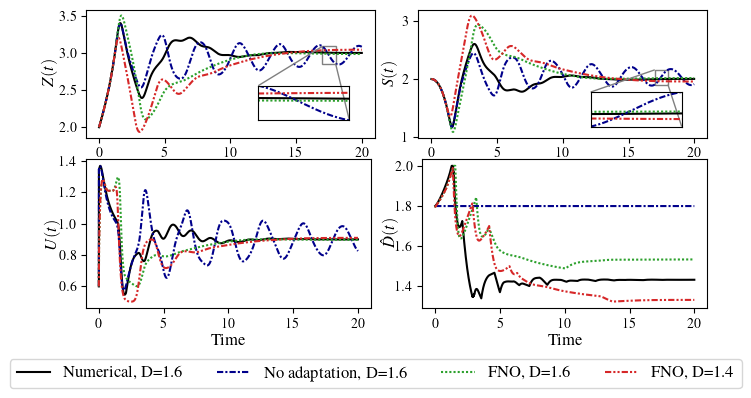

In [666]:
# Make a nice set of plots 
t = np.arange(0, T, dt)
res = 1
fig = plt.figure(figsize=set_size(504, 0.99, (2,2), height_add=0))
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),#0
     ('dotted',                (0, (1, 5))),#1
     ('densely dotted',        (0, (1, 1))),#2
     ('long dash with offset', (5, (10, 3))),#3
     ('loosely dashed',        (0, (5, 10))),#4
     ('dashed',                (0, (5, 5))),#5
     ('densely dashed',        (0, (5, 1))),#6
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),#7
     ('dashdotted',            (0, (3, 5, 1, 5))),#8
     ('densely dashdotted',    (0, (3, 1, 1, 1))),#9
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),#10
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),#11
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]#12

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.08, bottom=0.3, right=0.98, top=0.9, wspace=0.15, hspace=0.)
axes = subfig.subplots(nrows=1, ncols=2)

line1, =axes[0].plot(t, states[:, 0], color="black")
line2, =axes[0].plot(t, states_no_update[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
line3, =axes[0].plot(t,  statesMLFNO[:, 0], label="FNO, D=1.6", linestyle=linestyle_tuple[2][1],color="#2ca02c")
line4, =axes[0].plot(t,  statesMLFNO_short[:, 0], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

axes[0].set_ylabel("$Z(t)$", labelpad=1)

# Zoomed inset
axins = inset_axes(
    axes[0], 
    width="35%",     # adjust width as needed (percent of parent)
    height="30%",    # adjust height as needed
    loc='lower right',
    bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),  # (x0, y0, width, height) relative to axes[0]
    bbox_transform=axes[0].transAxes,
    borderpad=1,
)
axins.plot(t, states[:, 0], color="black")
axins.plot(t, states_no_update[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
axins.plot(t, statesMLFNO[:, 0], linestyle=linestyle_tuple[2][1],color="#2ca02c")
axins.plot(t, statesMLFNO_short[:, 0], linestyle=linestyle_tuple[12][1],color="#d62728")

# Set zoom region
axins.set_xlim(17, 18)
# Set y-limits to nicely frame that region
i1, i2 = (t >= 17).nonzero()[0][0], (t <= 18).nonzero()[0][-1]
ymin = min(states[i1:i2, 0].min(), states_no_update[i1:i2, 0].min(), 
           statesMLFNO[i1:i2, 0].min(), statesMLFNO_short[i1:i2, 0].min())
ymax = max(states[i1:i2, 0].max(), states_no_update[i1:i2, 0].max(), 
           statesMLFNO[i1:i2, 0].max(), statesMLFNO_short[i1:i2, 0].max())
axins.set_ylim(ymin, ymax)
axins.set_xticks([])
axins.set_yticks([])

# Add connecting lines
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

axes[1].plot(t, states[:, 1], color="black")
axes[1].plot(t, states_no_update[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t,  statesMLFNO[:, 1], label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
axes[1].plot(t,  statesMLFNO_short[:, 1], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

# Zoomed inset
axins = inset_axes(
    axes[1], 
    width="35%",     # adjust width as needed (percent of parent)
    height="30%",    # adjust height as needed
    loc='lower right',
    bbox_to_anchor=(0.05, 0, 0.9, 0.9),  # (x0, y0, width, height) relative to axes[0]
    bbox_transform=axes[1].transAxes,
    borderpad=1,
)
axins.plot(t, states[:, 1], color="black")
axins.plot(t, states_no_update[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
axins.plot(t, statesMLFNO[:, 1], linestyle=linestyle_tuple[2][1],color="#2ca02c")
axins.plot(t, statesMLFNO_short[:, 1], linestyle=linestyle_tuple[12][1],color="#d62728")

# Set zoom region
axins.set_xlim(17, 18)
# Set y-limits to nicely frame that region
i1, i2 = (t >= 17).nonzero()[0][0], (t <= 18).nonzero()[0][-1]
ymin = min(states[i1:i2, 1].min(), states_no_update[i1:i2, 1].min(), 
           statesMLFNO[i1:i2, 1].min(), statesMLFNO_short[i1:i2, 1].min())
ymax = max(states[i1:i2, 1].max(), states_no_update[i1:i2, 1].max(), 
           statesMLFNO[i1:i2, 1].max(), statesMLFNO_short[i1:i2, 1].max())
axins.set_ylim(ymin, ymax)
axins.set_xticks([])
axins.set_yticks([])

# Add connecting lines
mark_inset(axes[1], axins, loc1=2, loc2=4, fc="none", ec="0.5")

axes[1].set_ylabel("$S(t)$", labelpad=3)

# subfig = subfigs[1]
# axes = subfig.subplots(nrows=1, ncols=2)
# subfig.subplots_adjust(left=0.08, bottom=0.4, right=0.98, top=1.1, wspace=0.18, hspace=0.)

# axes[0].plot(t, pred_arr[:, 0], color="black")
# axes[0].plot(t, pred_arr_no_update[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
# axes[0].plot(t,  pred_arr_fno[:, 0], label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
# axes[0].plot(t,  pred_arr_fno_short[:, 0], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

# axes[0].set_ylabel("$P_1$", labelpad=1)

# axes[1].plot(t, pred_arr[:, 1], color="black")
# axes[1].plot(t, pred_arr_no_update[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
# axes[1].plot(t,  pred_arr_fno[:, 1], label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
# axes[1].plot(t,  pred_arr_fno_short[:, 1], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

# axes[1].set_ylabel("$P_2$", labelpad=3)

subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.08, bottom=0.5, right=0.98, top=1.2, wspace=0.18, hspace=0.)

axes[0].plot(t[1:], controls, label="Numerical $\hat{D}(0)=2$", color="black")
axes[0].plot(t[1:], controls_no_update, label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[0].plot(t[1:], controlsMLFNO, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[0].plot(t[1:], controlsMLFNO_short, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
            ,color="#d62728")
axes[0].set_ylabel("$U(t)$", labelpad=-1)
axes[0].set_xlabel("Time", labelpad=2)


axes[1].plot(t, delays, label="Numerical $\hat{D}(0)=2$", color="black")
axes[1].plot(t, delays_no_update, label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t, delaysMLFNO, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[1].plot(t, delaysMLFNO_short, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
            ,color="#d62728")
axes[1].set_xlabel("Time", labelpad=2)
axes[1].set_ylabel("$\hat{D}(t)$", labelpad=-2)

# Add a centered legend above the plot
subfig.legend([line1, line2, line3, line4], 
              labels=["Numerical, D=1.6", "No adaptation, D=1.6", "FNO, D=1.6", "FNO, D=1.4"],
              loc='upper center', 
              bbox_to_anchor=(0.5, .3), 
              ncol=4, fontsize=12)

plt.savefig("res.pdf", dpi=300)

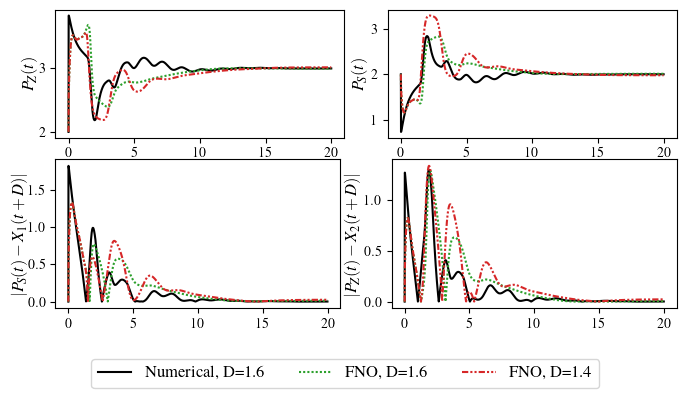

In [667]:
# Make a nice set of plots 
t = np.arange(0, T, dt)
res = 1
fig = plt.figure(figsize=set_size(504, 0.99, (2,2), height_add=0))
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),#0
     ('dotted',                (0, (1, 5))),#1
     ('densely dotted',        (0, (1, 1))),#2
     ('long dash with offset', (5, (10, 3))),#3
     ('loosely dashed',        (0, (5, 10))),#4
     ('dashed',                (0, (5, 5))),#5
     ('densely dashed',        (0, (5, 1))),#6
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),#7
     ('dashdotted',            (0, (3, 5, 1, 5))),#8
     ('densely dashdotted',    (0, (3, 1, 1, 1))),#9
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),#10
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),#11
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]#12

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.08, bottom=0.3, right=0.98, top=0.9, wspace=0.15, hspace=0.)
axes = subfig.subplots(nrows=1, ncols=2)

line1,  = axes[0].plot(t, pred_arr[:, 0], color="black")
#line2,  = axes[0].plot(t, pred_arr_no_update[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
line3,  = axes[0].plot(t,  pred_arr_fno[:, 0], label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
line4,  = axes[0].plot(t,  pred_arr_fno_short[:, 0], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

axes[0].set_ylabel("$P_Z(t)$", labelpad=1)

axes[1].plot(t, pred_arr[:, 1], color="black")
#axes[1].plot(t, pred_arr_no_update[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t,  pred_arr_fno[:, 1], label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
axes[1].plot(t,  pred_arr_fno_short[:, 1], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

axes[1].set_ylabel("$P_S(t)$", labelpad=3)

subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.08, bottom=0.5, right=0.98, top=1.2, wspace=0.18, hspace=0.)

axes[0].plot(t, abs(pred_arr[:, 0]-states[:, 0]), color="black")
#axes[0].plot(t, abs(pred_arr_no_update[:,0]-states_no_update[:, 0]), linestyle=linestyle_tuple[9][1], color="#00008B")
axes[0].plot(t,  abs(pred_arr_fno[:, 0]-statesMLFNO[:, 0]), label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
axes[0].plot(t,  abs(pred_arr_fno_short[:, 0]-statesMLFNO_short[:, 0]), label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

axes[0].set_ylabel("$|P_S(t)-X_1(t+D)|$", labelpad=1)

axes[1].plot(t, abs(pred_arr[:, 1]-states[:, 1]), color="black")
# axes[1].plot(t, abs(pred_arr_no_update[:,1]-states_no_update[:, 1]), linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t,  abs(pred_arr_fno[:, 1]-statesMLFNO[:, 1]), label="FNO", linestyle=linestyle_tuple[2][1],color="#2ca02c")
axes[1].plot(t,  abs(pred_arr_fno_short[:, 1]-statesMLFNO_short[:, 1]), label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="#d62728")

axes[1].set_ylabel("$|P_Z(t)-X_2(t+D)|$", labelpad=3)

# Add a centered legend above the plot
subfig.legend([line1,  line3, line4], 
              labels=["Numerical, D=1.6", "FNO, D=1.6", "FNO, D=1.4"],
              loc='upper center', 
              bbox_to_anchor=(0.5, .3), 
              ncol=4, fontsize=12)

plt.savefig("resErrors.pdf", dpi=300)

<h3> Generalization of FNO across various initial conditions </h3>

In [653]:
T = 35
x0 = [5, 5]
D = 1.6
statesMLFNO_cond_1, predictionsMLFNO_cond_1, controlsMLFNO_cond_1, pde_solMLFNO_cond_1, delaysMLFNO_cond_1 = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=ml_predictor_fno, model=modelBetterFNO)
x0 = [2, 2]

statesMLFNO_cond_2, predictionsMLFNO_cond_2, controlsMLFNO_cond_2, pde_solMLFNO_cond_2, delaysMLFNO_cond_2 = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=ml_predictor_fno, model=modelBetterFNO)
x0 = [0.1, 0.1]

statesMLFNO_cond_3, predictionsMLFNO_cond_3, controlsMLFNO_cond_3, pde_solMLFNO_cond_3, delaysMLFNO_cond_3 = \
    simulate_system_with_delay_estimate(x0, T, dt, dx, D, D_est, predictor_func=ml_predictor_fno, model=modelBetterFNO)

In [654]:
pred_arr_fno_cond_1 = [predictionsMLFNO_cond_1[0]]
pred_arr_fno_cond_2 = [predictionsMLFNO_cond_2[0]]
pred_arr_fno_cond_3 = [predictionsMLFNO_cond_3[0]]

for i in range(1, len(predictionsMLFNO_cond_1)):
    pred_arr_fno_cond_1.append(predictionsMLFNO_cond_1[i][-1])
    pred_arr_fno_cond_2.append(predictionsMLFNO_cond_2[i][-1])
    pred_arr_fno_cond_3.append(predictionsMLFNO_cond_3[i][-1])


pred_arr_fno_cond_1 = np.array(pred_arr_fno_cond_1)
pred_arr_fno_cond_2 = np.array(pred_arr_fno_cond_2)
pred_arr_fno_cond_3 = np.array(pred_arr_fno_cond_3)



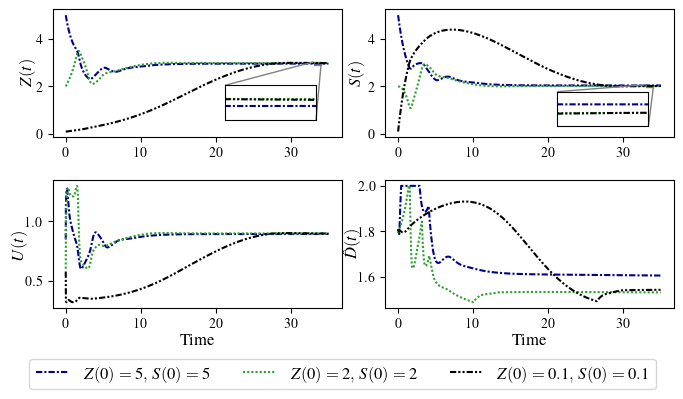

In [661]:
# Make a nice set of plots 
t = np.arange(0, T, dt)
res = 1
fig = plt.figure(figsize=set_size(504, 0.99, (2,2), height_add=0))
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),#0
     ('dotted',                (0, (1, 5))),#1
     ('densely dotted',        (0, (1, 1))),#2
     ('long dash with offset', (5, (10, 3))),#3
     ('loosely dashed',        (0, (5, 10))),#4
     ('dashed',                (0, (5, 5))),#5
     ('densely dashed',        (0, (5, 1))),#6
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),#7
     ('dashdotted',            (0, (3, 5, 1, 5))),#8
     ('densely dashdotted',    (0, (3, 1, 1, 1))),#9
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),#10
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),#11
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]#12

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.08, bottom=0.3, right=0.98, top=0.9, wspace=0.15, hspace=0.)
axes = subfig.subplots(nrows=1, ncols=2)

line2, =axes[0].plot(t, statesMLFNO_cond_1[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
line3, =axes[0].plot(t,  statesMLFNO_cond_2[:, 0], label="FNO, D=1.6", linestyle=linestyle_tuple[2][1],color="#2ca02c")
line4, =axes[0].plot(t,  statesMLFNO_cond_3[:, 0], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="black")

axes[0].set_ylabel("$Z(t)$", labelpad=1)

# Zoomed inset
axins = inset_axes(
    axes[0], 
    width="35%",     # adjust width as needed (percent of parent)
    height="30%",    # adjust height as needed
    loc='lower right',
    bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),  # (x0, y0, width, height) relative to axes[0]
    bbox_transform=axes[0].transAxes,
    borderpad=1,
)
axins.plot(t, statesMLFNO_cond_1[:,0], linestyle=linestyle_tuple[9][1], color="#00008B")
axins.plot(t, statesMLFNO_cond_2[:, 0], linestyle=linestyle_tuple[2][1],color="#2ca02c")
axins.plot(t, statesMLFNO_cond_3[:, 0], linestyle=linestyle_tuple[12][1],color="black")

# Set zoom region
axins.set_xlim(33, 34)
# Set y-limits to nicely frame that region
i1, i2 = (t >= 33).nonzero()[0][0], (t <= 34).nonzero()[0][-1]
ymin = min(statesMLFNO_cond_1[i1:i2, 0].min(), 
           statesMLFNO_cond_2[i1:i2, 0].min(), statesMLFNO_cond_3[i1:i2, 0].min())
ymax = max(statesMLFNO_cond_1[i1:i2, 0].max(), 
           statesMLFNO_cond_2[i1:i2, 0].max(), statesMLFNO_cond_3[i1:i2, 0].max())
axins.set_ylim(ymin - (ymin+ymax)/120, ymax+  (ymin+ymax)/120)
axins.set_xticks([])
axins.set_yticks([])

# Add connecting lines
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")



line2, =axes[1].plot(t, statesMLFNO_cond_1[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
line3, =axes[1].plot(t,  statesMLFNO_cond_2[:, 1], label="FNO, D=1.6", linestyle=linestyle_tuple[2][1],color="#2ca02c")
line4, =axes[1].plot(t,  statesMLFNO_cond_3[:, 1], label="FNO, D=1.4", linestyle=linestyle_tuple[12][1],color="black")

# Zoomed inset
axins = inset_axes(
    axes[1], 
    width="35%",     # adjust width as needed (percent of parent)
    height="30%",    # adjust height as needed
    loc='lower right',
    bbox_to_anchor=(0.05, 0, 0.9, 0.9),  # (x0, y0, width, height) relative to axes[0]
    bbox_transform=axes[1].transAxes,
    borderpad=1,
)
axins.plot(t, statesMLFNO_cond_1[:,1], linestyle=linestyle_tuple[9][1], color="#00008B")
axins.plot(t, statesMLFNO_cond_2[:, 1], linestyle=linestyle_tuple[2][1],color="#2ca02c")
axins.plot(t, statesMLFNO_cond_3[:, 1], linestyle=linestyle_tuple[12][1],color="black")

# Set zoom region
axins.set_xlim(33, 34)
# Set y-limits to nicely frame that region
i1, i2 = (t >= 33).nonzero()[0][0], (t <= 34).nonzero()[0][-1]
ymin = min(statesMLFNO_cond_1[i1:i2, 1].min(), 
           statesMLFNO_cond_2[i1:i2, 1].min(), statesMLFNO_cond_3[i1:i2, 1].min())
ymax = max(statesMLFNO_cond_1[i1:i2, 1].max(), 
           statesMLFNO_cond_2[i1:i2, 1].max(), statesMLFNO_cond_3[i1:i2, 1].max())
axins.set_ylim(ymin - (ymin+ymax)/120, ymax+  (ymin+ymax)/120)
axins.set_xticks([])
axins.set_yticks([])

mark_inset(axes[1], axins, loc1=2, loc2=4, fc="none", ec="0.5")


axes[1].set_ylabel("$S(t)$", labelpad=3)


subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.08, bottom=0.5, right=0.98, top=1.1, wspace=0.15, hspace=0.)

axes[0].plot(t[1:], controlsMLFNO_cond_1, label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[0].plot(t[1:], controlsMLFNO_cond_2, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[0].plot(t[1:], controlsMLFNO_cond_3, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
            ,color="black")
axes[0].set_ylabel("$U(t)$", labelpad=-1)
axes[0].set_xlabel("Time", labelpad=2)


axes[1].plot(t, delaysMLFNO_cond_1, label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t, delaysMLFNO_cond_2, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[1].plot(t, delaysMLFNO_cond_3, label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
            ,color="black")
axes[1].set_xlabel("Time", labelpad=2)
axes[1].set_ylabel("$\hat{D}(t)$", labelpad=-2)

# Add a centered legend above the plot
subfig.legend([line2, line3, line4], 
              labels=[r"$Z(0)=5,$" + " " + r"$S(0) = 5$", r"$Z(0)=2,$" + " " + r"$S(0) = 2$", r"$Z(0)=0.1,$" + " " + r"$S(0) = 0.1$",],
              loc='upper center', 
              bbox_to_anchor=(0.5, .3), 
              ncol=4, fontsize=12)

plt.savefig("resGeneralization.pdf", dpi=300)

In [ ]:
# Get speedups
dx = 0.01
x = np.arange(0, 1, dx)
state = [0.01, 30]
# Make a 400 grid
spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
print(grid.shape)
m = grid.shape[0]
dim_x = grid.shape[1]


modelDeepONet = DeepONetProjected(m, dim_x, 2*len(x), 2*len(x)).to(device)
modelFNO = FNOProjected(m, dim_x, 2*len(x), 2*len(x), 8, 16).to(device)

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)

In [ ]:
# Get speedups
dx = 0.005
x = np.arange(0, 1, dx)
state = [0.01, 30]
# Make a 400 grid
spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
print(grid.shape)
m = grid.shape[0]
dim_x = grid.shape[1]


modelDeepONet = DeepONetProjected(m, dim_x, 2*len(x), 2*len(x)).to(device)
modelFNO = FNOProjected(m, dim_x, 2*len(x), 2*len(x), 8, 16).to(device)

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)

In [ ]:
# Get speedups
dx = 0.001
x = np.arange(0, 1, dx)
state = [0.01, 30]
# Make a 400 grid
spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
print(grid.shape)
m = grid.shape[0]
dim_x = grid.shape[1]


modelDeepONet = DeepONetProjected(m, dim_x, 2*len(x), 2*len(x)).to(device)
modelFNO = FNOProjected(m, dim_x, 2*len(x), 2*len(x), 8, 16).to(device)

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).to(device)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)